<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/NewApp_Dec27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries


In [1]:
!pip install datasets -q
!pip install torchmetrics

import os
import glob
import random
from PIL import Image
from torch.utils.data import Dataset, random_split
from datasets import Dataset, DatasetDict
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 44.0 MB/s eta 0:00:00


# Step 2: Add Checkpoints


In [2]:
from google.colab import drive
drive.mount('/content/drive')

model_name = "video-xlstm-1"
CHECKPOINTS_DIR = '/content/drive/MyDrive/ckpts'

def save_checkpoint(model, optimizer, epoch):
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    checkpoint_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved for {model_name} at epoch {epoch}.")

def load_checkpoint(model, optimizer):
    ckpt_path = f'{CHECKPOINTS_DIR}/{model_name}.pth'
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found for {model_name}, starting from epoch 0.")
        return 0

    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded for {model_name} from {ckpt_path}. Resuming from epoch {start_epoch}.")
    return start_epoch


Mounted at /content/drive


# Step 3: Add Dataset

In [3]:
!pip install kagglehub
import kagglehub

path = kagglehub.dataset_download("pevogam/ucf101-frames")
print("Path to dataset files:", path)


100%|██████████| 8.85G/8.85G [07:25<00:00, 21.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pevogam/ucf101-frames/versions/2


# Step 4: Prepare Image Dataset

276255
9


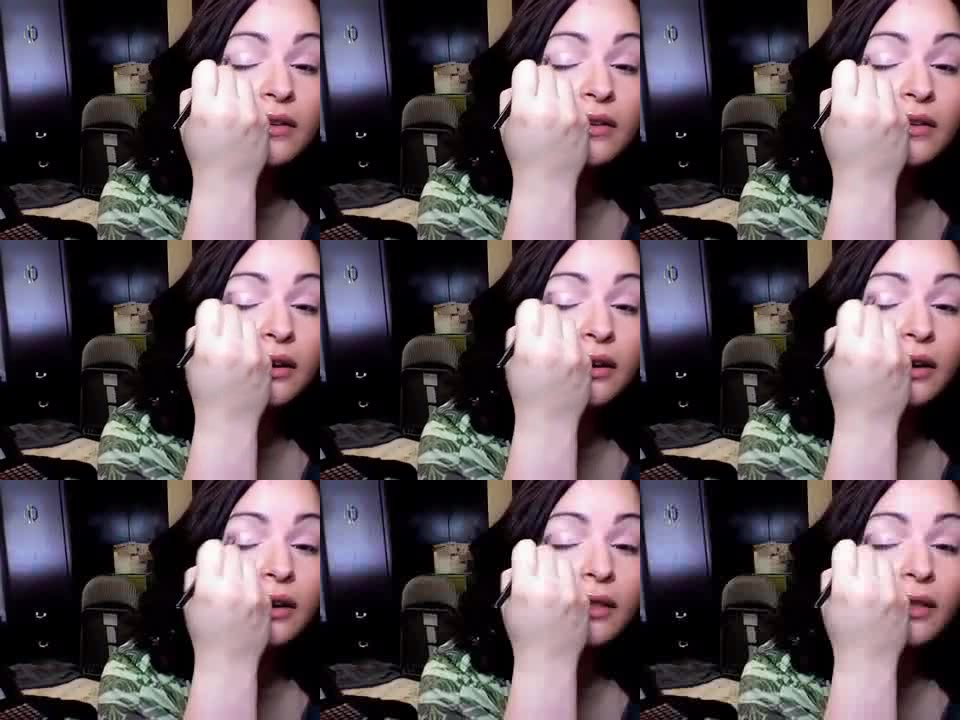

In [4]:
file_list = sorted(glob.glob(os.path.join(path, '**', '*.jpg'), recursive=True))
grouped = [file_list[i:i + 9] for i in range(0, len(file_list), 9)]

class ImageGridDataset(Dataset):
    def __init__(self, image_groups, transform=None):
        self.image_groups = image_groups
        self.transform = transform

    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, idx):
        image_paths = self.image_groups[idx]
        images = [Image.open(path).convert("RGB") for path in image_paths]
        if self.transform:
            images = [self.transform(img) for img in images]
        grid_image = self._create_grid(images)
        return grid_image

    def _create_grid(self, images):
        assert len(images) == 9, "There must be exactly 9 images to create a 3x3 grid."
        width, height = images[0].size
        grid_width, grid_height = width * 3, height * 3
        grid_image = Image.new("RGB", (grid_width, grid_height))
        for idx, img in enumerate(images):
            x_offset = (idx % 3) * width
            y_offset = (idx // 3) * height
            grid_image.paste(img, (x_offset, y_offset))
        return grid_image

print(len(grouped))
print(len(grouped[0]))
dataset = ImageGridDataset(grouped)
grid_image = dataset[0]
grid_image


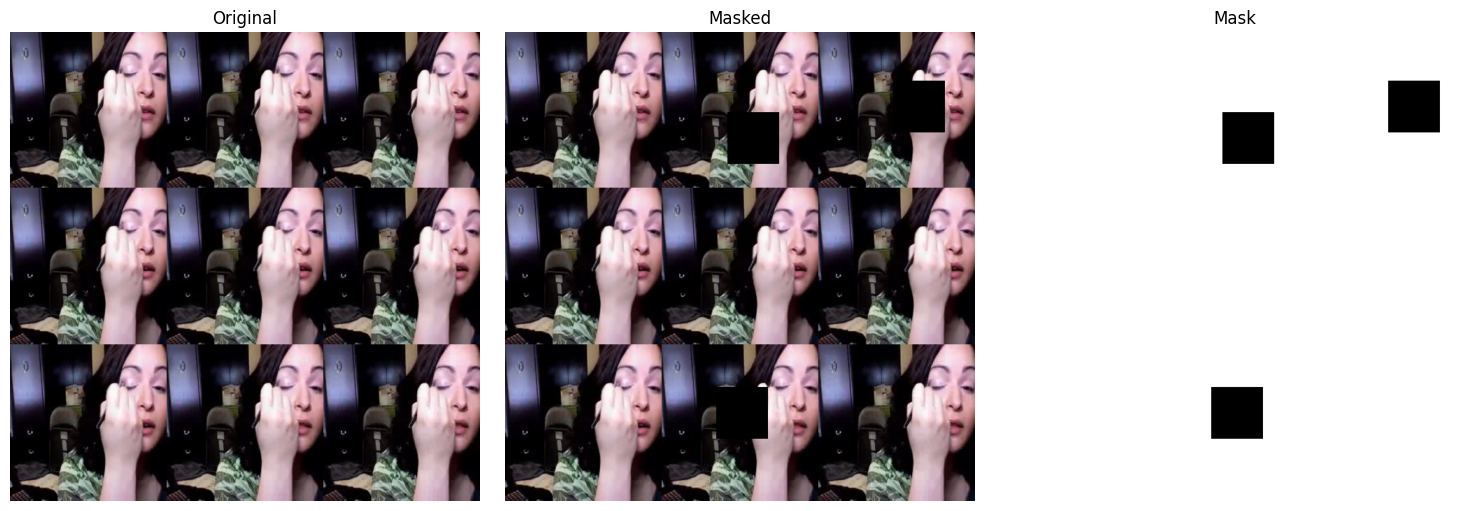

In [5]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class MaskedImageGridDataset(Dataset):
    def __init__(self, image_groups, image_size=(224, 224), num_masks=3):
        """
        Args:
            image_groups (list of list of str): Nested list where each inner list contains paths to 9 images
            image_size (tuple): Size to resize individual images to (height, width)
            num_masks (int): Number of rectangular masks to apply
        """
        self.image_groups = image_groups
        self.individual_size = image_size
        self.grid_size = (image_size[0] * 3, image_size[1] * 3)
        self.num_masks = num_masks

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def generate_rectangular_masks(self):
        """Generate random rectangular masks for individual grid cells."""
        mask = torch.ones((1, self.grid_size[0], self.grid_size[1]))

        for _ in range(self.num_masks):
            # Randomly select a grid cell (0-8)
            cell_idx = np.random.randint(0, 9)
            row = cell_idx // 3
            col = cell_idx % 3

            # Calculate base position for the selected cell
            base_h = row * self.individual_size[0]
            base_w = col * self.individual_size[1]

            # Create a rectangular mask within the cell
            # Make mask size about 1/3 of the cell size
            mask_h = self.individual_size[0] // 3
            mask_w = self.individual_size[1] // 3

            # Random position within the cell
            h_start = base_h + np.random.randint(0, self.individual_size[0] - mask_h)
            w_start = base_w + np.random.randint(0, self.individual_size[1] - mask_w)

            # Apply rectangular mask
            mask[:, h_start:h_start + mask_h, w_start:w_start + mask_w] = 0

        return mask

    def __len__(self):
        return len(self.image_groups)

    def __getitem__(self, idx):
        image_paths = self.image_groups[idx]
        images = [self.transform(Image.open(path).convert("RGB")) for path in image_paths]
        grid_image = self._create_tensor_grid(images)

        # Generate rectangular masks
        mask = self.generate_rectangular_masks()

        # Apply mask to image
        masked_image = grid_image * mask

        return {
            'original': grid_image,
            'masked': masked_image,
            'mask': mask
        }

    def _create_tensor_grid(self, images):
        """Create a grid from tensor images."""
        assert len(images) == 9, "There must be exactly 9 images to create a 3x3 grid."

        grid_tensor = torch.zeros((3, self.grid_size[0], self.grid_size[1]))

        for idx, img_tensor in enumerate(images):
            row = idx // 3
            col = idx % 3
            h_start = row * self.individual_size[0]
            w_start = col * self.individual_size[1]
            h_end = h_start + self.individual_size[0]
            w_end = w_start + self.individual_size[1]

            grid_tensor[:, h_start:h_end, w_start:w_end] = img_tensor

        return grid_tensor

def visualize_masked_images(dataset_item):
    """Visualize original, masked image and mask"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(dataset_item['original'].permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Masked image
    axes[1].imshow(dataset_item['masked'].permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title('Masked')
    axes[1].axis('off')

    # Mask
    axes[2].imshow(dataset_item['mask'].squeeze(), cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Create dataset and test
dataset = MaskedImageGridDataset(
    grouped,
    image_size=(224, 224),
    num_masks=3  # Adjust number of masks as needed
)

# Test with one sample
sample = dataset[0]
visualize_masked_images(sample)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ... (other imports and classes)

class CrossLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CrossLSTMCell, self).__init__()
        self.hidden_size = hidden_size

        # Horizontal LSTM gates
        self.h_gates = nn.Linear(input_size + hidden_size, 4 * hidden_size) #This layer handles (input_size + hidden_size) dimensional input

        # Vertical LSTM gates
        self.v_gates = nn.Linear(input_size + hidden_size, 4 * hidden_size)  #This layer handles (input_size + hidden_size) dimensional input

    def forward(self, x, h_prev, c_prev, direction='h'):
        # Select appropriate gates based on direction
        gates = self.h_gates if direction == 'h' else self.v_gates

        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)

        # Calculate gates
        gates_output = gates(combined)  # Apply linear transformation with gates (h_gates or v_gates)
        i, f, g, o = gates_output.chunk(4, dim=1) # Split the output into 4 gates

        # Apply gate functions
        i = torch.sigmoid(i) # Input gate
        f = torch.sigmoid(f) # Forget gate
        g = torch.tanh(g)    # Cell gate
        o = torch.sigmoid(o) # Output gate

        # Update cell state and hidden state
        c_next = f * c_prev + i * g # Update cell state
        h_next = o * torch.tanh(c_next) # Update hidden state

        return h_next, c_next

class XLSTMInpaintingModel(nn.Module):
    def __init__(self, input_channels=3, hidden_size=128):
        super(XLSTMInpaintingModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels + 1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, hidden_size, kernel_size=3, padding=1),  # Output channels is hidden_size
            nn.ReLU()
        )

        # XLSTM layer
        self.xlstm_cell = CrossLSTMCell(hidden_size, hidden_size) # Input size and hidden size are both hidden_size
        self.hidden_size = hidden_size # Store hidden_size

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_size, 128, kernel_size=3, padding=1), # Input channels is hidden_size
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, input_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def _process_xlstm(self, x, batch_size, height, width):
        # Initialize hidden and cell states
        h = torch.zeros(batch_size, self.hidden_size, height, width).to(x.device) # Hidden state with hidden_size channels
        c = torch.zeros(batch_size, self.hidden_size, height, width).to(x.device) # Cell state with hidden_size channels

        # Process horizontal direction
        for i in range(width):
            h_prev = h[:, :, :, i:i+1].squeeze(-1) # Get previous hidden state for current column
            c_prev = c[:, :, :, i:i+1].squeeze(-1) # Get previous cell state for current column
            x_slice = x[:, :, :, i]                # Get input slice for current column

            h_next, c_next = self.xlstm_cell(x_slice, h_prev, c_prev, 'h') # Process through XLSTM cell (horizontal)
            h[:, :, :, i] = h_next # Update hidden state for current column
            c[:, :, :, i] = c_next # Update cell state for current column

        # Process vertical direction
        for j in range(height):
            h_prev = h[:, :, j:j+1, :].squeeze(-2) # Get previous hidden state for current row
            c_prev = c[:, :, j:j+1, :].squeeze(-2) # Get previous cell state for current row
            x_slice = x[:, :, j, :]                # Get input slice for current row

            h_next, c_next = self.xlstm_cell(x_slice, h_prev, c_prev, 'v') # Process through XLSTM cell (vertical)
            h[:, :, j, :] = h_next # Update hidden state for current row
            c[:, :, j, :] = c_next # Update cell state for current row

        return h

    def forward(self, x, mask):
        # Concatenate input image and mask
        x_masked = torch.cat([x, mask], dim=1) # Concatenate along channel dimension

        # Encode
        encoded = self.encoder(x_masked) # Pass through encoder

        # Get dimensions
        batch_size, channels, height, width = encoded.shape # Get dimensions of encoded output

        # Process through XLSTM
        xlstm_out = self._process_xlstm(encoded, batch_size, height, width) # Process through XLSTM layer

        # Decode
        output = self.decoder(xlstm_out) # Pass through decoder

        # Use mask to combine original and inpainted regions
        return x * mask + output * (1 - mask) # Combine original and inpainted regions using mask

This architecture implements a novel **XLSTM-based inpainting model**. Here's an explanation of its components and functionality:

---

### **Purpose**
The model is designed for **image inpainting**, where missing or corrupted parts of an image are reconstructed based on the available data. It uses a custom LSTM variation called **CrossLSTM (XLSTM)** to model dependencies in two dimensions (horizontal and vertical) for more robust feature learning, making it suitable for image-based tasks.

---

### **Key Components**
#### **1. CrossLSTMCell**
- **Purpose**: Models the spatial dependencies within the image features.
- **Mechanism**:
  - Processes input data in **two directions**:
    - Horizontal (`direction='h'`)
    - Vertical (`direction='v'`)
  - Each direction has its own LSTM-like gates:
    - **Input Gate (i)**: Determines how much of the current input should be stored.
    - **Forget Gate (f)**: Controls how much of the previous state is forgotten.
    - **Cell Gate (g)**: Encodes new information into the cell state.
    - **Output Gate (o)**: Regulates the output based on the cell state.
  - Updates the **hidden state (h_next)** and **cell state (c_next)** accordingly.

#### **2. Encoder**
- **Purpose**: Extracts low-level to high-level features from the input image and mask.
- **Architecture**:
  - Uses **3 convolutional layers** to process the concatenated input image and mask. The final output has `hidden_size` channels.
  - Activations are passed through **ReLU**, which introduces non-linearity.

#### **3. XLSTM Layer**
- **Purpose**: Processes encoded features to capture spatial relationships in both horizontal and vertical directions.
- **Mechanism**:
  - Initializes hidden (`h`) and cell (`c`) states with zeros.
  - Iteratively processes:
    - **Horizontal slices**: Across each column (`width`) for all rows (`height`).
    - **Vertical slices**: Across each row (`height`) for all columns (`width`).
  - Updates hidden and cell states in both directions using the **CrossLSTMCell**.

#### **4. Decoder**
- **Purpose**: Reconstructs the inpainted image from the processed features.
- **Architecture**:
  - Uses **3 convolutional layers** with decreasing channels (from `hidden_size` back to the input channels).
  - Activations:
    - **ReLU**: For intermediate layers.
    - **Sigmoid**: For the output layer to normalize pixel values between 0 and 1.

#### **5. Forward Pass**
- **Input**:
  - `x`: Input image with missing regions.
  - `mask`: Binary mask (1 for available regions, 0 for missing regions).
- **Steps**:
  1. **Concatenate** `x` and `mask` along the channel dimension.
  2. **Encode** the concatenated input using the encoder.
  3. **Process encoded features** using the XLSTM layer to capture spatial dependencies.
  4. **Decode** the XLSTM output to reconstruct the inpainted image.
  5. **Combine** the original image and inpainted regions using the mask:
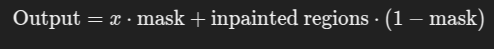

---

### **Advantages**
1. **CrossLSTM**:
   - Explores **spatial dependencies** in both horizontal and vertical directions, improving context understanding.
   - Captures fine-grained details, essential for inpainting tasks.
2. **End-to-End Architecture**:
   - Combines feature extraction (encoder), spatial modeling (XLSTM), and reconstruction (decoder) in a unified pipeline.
3. **Mask-Aware**:
   - The input mask ensures that the model distinguishes between observed and missing regions, focusing its efforts on inpainting.

---

### **Application**
The model is ideal for tasks like:
- Image inpainting (filling missing parts of an image).
- Medical imaging reconstruction.
- Satellite image restoration.

This architecture effectively balances **contextual feature learning** (via XLSTM) and **high-quality reconstruction** (via encoder-decoder).

In [ ]:
# Create model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XLSTMInpaintingModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = InpaintingLoss()

# Create DataLoader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

    if (epoch + 1) % 5 == 0:  # Save checkpoint every 5 epochs
        save_checkpoint(model, optimizer, epoch)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.72 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.53 GiB is free. Process 7241 has 13.21 GiB memory in use. Of the allocated memory 12.37 GiB is allocated by PyTorch, and 744.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Dec 28

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FrameEncoder(nn.Module):
    """Encodes individual frames into feature vectors"""
    def __init__(self, feature_dim=1024):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, feature_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class FrameDecoder(nn.Module):
    """Decodes feature vectors back to frames"""
    def __init__(self, feature_dim=1024, image_size=224):
        super().__init__()
        self.image_size = image_size
        self.initial_size = image_size // 16  # After 4 upsampling operations

        self.linear = nn.Linear(feature_dim, 512 * self.initial_size * self.initial_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Reshape feature vector to spatial form
        x = self.linear(x)
        x = x.view(-1, 512, self.initial_size, self.initial_size)
        return self.decoder(x)

class CrossLSTMCell(nn.Module):
    """Cross-LSTM cell for processing feature vectors in 2D grid"""
    def __init__(self, feature_dim):
        super().__init__()
        self.feature_dim = feature_dim

        # Horizontal and vertical LSTM cells
        self.h_lstm = nn.LSTMCell(feature_dim, feature_dim)
        self.v_lstm = nn.LSTMCell(feature_dim, feature_dim)

    def forward(self, x, h_state, v_state, direction='h'):
        if direction == 'h':
            return self.h_lstm(x, h_state)
        else:
            return self.v_lstm(x, v_state)

class FeatureInpaintingXLSTM(nn.Module):
    """Main model combining encoder, XLSTM, and decoder"""
    def __init__(self, feature_dim=1024, image_size=224, grid_size=3):
        super().__init__()
        self.feature_dim = feature_dim
        self.grid_size = grid_size

        self.encoder = FrameEncoder(feature_dim=feature_dim)
        self.decoder = FrameDecoder(feature_dim=feature_dim, image_size=image_size)
        self.xlstm_cell = CrossLSTMCell(feature_dim=feature_dim)

    def encode_grid(self, grid_images, mask):
        """Encode each frame in the grid to feature vectors"""
        batch_size = grid_images.shape[0]
        # Reshape grid to individual frames
        frames = grid_images.view(batch_size, self.grid_size * self.grid_size, 3,
                                grid_images.shape[-2] // self.grid_size,
                                grid_images.shape[-1] // self.grid_size)

        # Encode each frame
        features = []
        for i in range(self.grid_size * self.grid_size):
            feature = self.encoder(frames[:, i])
            features.append(feature)

        features = torch.stack(features, dim=1)  # [batch_size, 9, feature_dim]
        features = features.view(batch_size, self.grid_size, self.grid_size, -1)  # [batch_size, 3, 3, feature_dim]

        # Apply mask to features
        mask_reshaped = mask.view(batch_size, self.grid_size, self.grid_size, 1)
        features = features * mask_reshaped  # Mask features

        return features

    def process_xlstm(self, features):
        """Process features with XLSTM to predict missing features"""
        batch_size = features.shape[0]
        h_state = (torch.zeros(batch_size, self.feature_dim).to(features.device),
                  torch.zeros(batch_size, self.feature_dim).to(features.device))
        v_state = (torch.zeros(batch_size, self.feature_dim).to(features.device),
                  torch.zeros(batch_size, self.feature_dim).to(features.device))

        # Process horizontal direction
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                curr_feature = features[:, i, j]
                h_state = self.xlstm_cell(curr_feature, h_state, v_state, 'h')
                features[:, i, j] = h_state[0]

        # Process vertical direction
        for j in range(self.grid_size):
            for i in range(self.grid_size):
                curr_feature = features[:, i, j]
                v_state = self.xlstm_cell(curr_feature, h_state, v_state, 'v')
                features[:, i, j] = v_state[0]

        return features

    def decode_grid(self, features):
        """Decode features back to images"""
        batch_size = features.shape[0]
        features = features.view(batch_size, self.grid_size * self.grid_size, -1)

        # Decode each feature vector
        frames = []
        for i in range(self.grid_size * self.grid_size):
            frame = self.decoder(features[:, i])
            frames.append(frame)

        frames = torch.stack(frames, dim=1)

        # Reshape back to grid
        grid_size = frames.shape[-1]
        output = frames.view(batch_size, self.grid_size, self.grid_size, 3, grid_size, grid_size)
        output = output.permute(0, 3, 1, 4, 2, 5)
        output = output.reshape(batch_size, 3, self.grid_size * grid_size, self.grid_size * grid_size)

        return output

    def forward(self, grid_images, mask):
        # Encode frames to feature vectors
        features = self.encode_grid(grid_images, mask)

        # Process with XLSTM to predict missing features
        processed_features = self.process_xlstm(features)

        # Decode features back to images
        output = self.decode_grid(processed_features)

        # Combine with original using mask
        return grid_images * mask + output * (1 - mask)

def train_model(model, train_loader, num_epochs=50, device='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            original = batch['original'].to(device)
            masked = batch['masked'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            output = model(masked, mask)
            loss = criterion(output * (1 - mask), original * (1 - mask))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, epoch)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def visualize_features(features, title="Feature Visualization"):
    """Visualize feature vectors as a heatmap"""
    features_mean = features.mean(dim=-1).detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(features_mean, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()

def visualize_step(batch_orig, batch_masked, features, processed_features, output, step):
    """Visualize each step of the process"""
    plt.figure(figsize=(15, 5))

    # Original
    plt.subplot(151)
    plt.imshow(batch_orig[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Original")
    plt.axis('off')

    # Masked
    plt.subplot(152)
    plt.imshow(batch_masked[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Masked Input")
    plt.axis('off')

    # Feature map
    plt.subplot(153)
    feature_vis = features[0].mean(dim=-1).cpu().detach().numpy()
    plt.imshow(feature_vis, cmap='viridis')
    plt.title("Encoded Features")
    plt.axis('off')

    # Processed Features
    plt.subplot(154)
    proc_vis = processed_features[0].mean(dim=-1).cpu().detach().numpy()
    plt.imshow(proc_vis, cmap='viridis')
    plt.title("XLSTM Features")
    plt.axis('off')

    # Output
    plt.subplot(155)
    plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Output")
    plt.axis('off')

    plt.suptitle(f'Step {step}')
    plt.tight_layout()
    plt.show()

class FrameEncoder(nn.Module):
    def __init__(self, feature_dim=1024):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, feature_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class FrameDecoder(nn.Module):
    def __init__(self, feature_dim=1024, image_size=224):
        super().__init__()
        self.initial_size = image_size // 16

        self.linear = nn.Linear(feature_dim, 512 * self.initial_size * self.initial_size)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, self.initial_size, self.initial_size)
        return self.decoder(x)

class CrossLSTMCell(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.h_lstm = nn.LSTMCell(feature_dim, feature_dim)
        self.v_lstm = nn.LSTMCell(feature_dim, feature_dim)

    def forward(self, x, h_state, v_state, direction='h'):
        if direction == 'h':
            return self.h_lstm(x, h_state)
        return self.v_lstm(x, v_state)

class FeatureXLSTM(nn.Module):
    def __init__(self, feature_dim=1024, image_size=224, grid_size=3):
        super().__init__()
        self.feature_dim = feature_dim
        self.grid_size = grid_size

        self.encoder = FrameEncoder(feature_dim)
        self.decoder = FrameDecoder(feature_dim, image_size)
        self.xlstm_cell = CrossLSTMCell(feature_dim)

    def encode_grid(self, grid_images):
        b, c, h, w = grid_images.shape
        frame_h = h // self.grid_size
        frame_w = w // self.grid_size

        features = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                frame = grid_images[:, :,
                                  i*frame_h:(i+1)*frame_h,
                                  j*frame_w:(j+1)*frame_w]
                feature = self.encoder(frame)
                features.append(feature)

        features = torch.stack(features, dim=1)
        return features.view(-1, self.grid_size, self.grid_size, self.feature_dim)

    def process_xlstm(self, features):
        b = features.shape[0]
        device = features.device

        # Initialize states
        h_state = (torch.zeros(b, self.feature_dim).to(device),
                  torch.zeros(b, self.feature_dim).to(device))
        v_state = (torch.zeros(b, self.feature_dim).to(device),
                  torch.zeros(b, self.feature_dim).to(device))

        # Create new tensor for output features
        processed_features = features.clone()

        # Horizontal pass
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                feat = processed_features[:, i, j]
                h_next, c_next = self.xlstm_cell(feat, h_state, v_state, 'h')
                h_state = (h_next, c_next)
                processed_features = processed_features.clone()
                processed_features[:, i, j] = h_next

        # Vertical pass
        for j in range(self.grid_size):
            for i in range(self.grid_size):
                feat = processed_features[:, i, j]
                v_next, c_next = self.xlstm_cell(feat, h_state, v_state, 'v')
                v_state = (v_next, c_next)
                processed_features = processed_features.clone()
                processed_features[:, i, j] = v_next

        return processed_features

    def decode_grid(self, features):
        b = features.shape[0]
        features_flat = features.reshape(b * self.grid_size * self.grid_size, -1)

        frames = self.decoder(features_flat)

        frame_size = frames.shape[-1]
        frames = frames.view(b, self.grid_size, self.grid_size, 3, frame_size, frame_size)
        frames = frames.permute(0, 3, 1, 4, 2, 5)
        return frames.reshape(b, 3, self.grid_size * frame_size, self.grid_size * frame_size)

    def forward(self, x, mask):
        # Encode features
        features = self.encode_grid(x)

        # Apply mask to features
        mask_downsized = F.interpolate(mask, size=(self.grid_size, self.grid_size))
        masked_features = features * mask_downsized.view(-1, self.grid_size, self.grid_size, 1)

        # Process with XLSTM
        processed_features = self.process_xlstm(masked_features)

        # Decode
        output = self.decode_grid(processed_features)

        # Combine with original using mask
        return x * mask + output * (1 - mask), features, processed_features

def train_model(model, train_loader, num_epochs=50, device='cuda'):
    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            original = batch['original'].to(device)
            masked = batch['masked'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()

            # Forward pass
            output, features, processed_features = model(masked, mask)
            loss = criterion(output * (1 - mask), original * (1 - mask))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 50 == 0:
                with torch.no_grad():  # Add this to prevent gradient issues during visualization
                    visualize_step(original, masked, features, processed_features, output,
                                 f"Epoch {epoch+1}, Batch {batch_idx}")
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

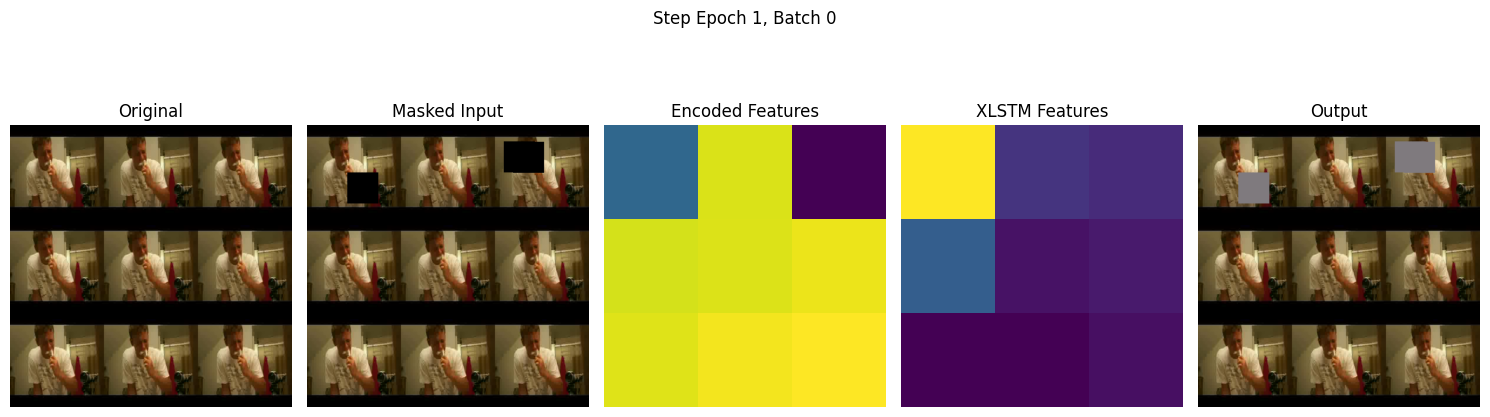

Epoch 1, Batch 0, Loss: 0.0068


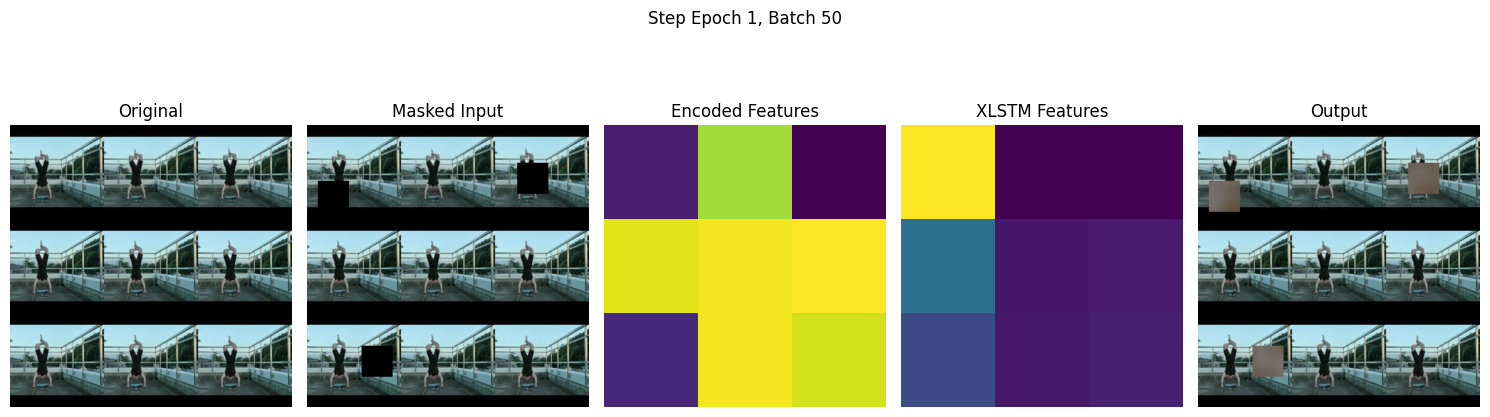

Epoch 1, Batch 50, Loss: 0.0069


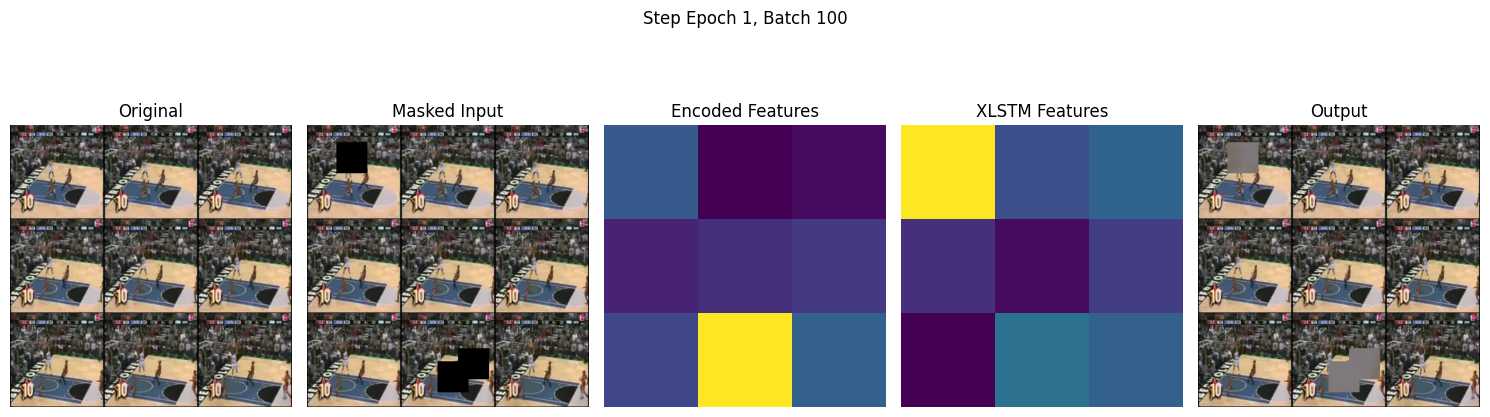

Epoch 1, Batch 100, Loss: 0.0081


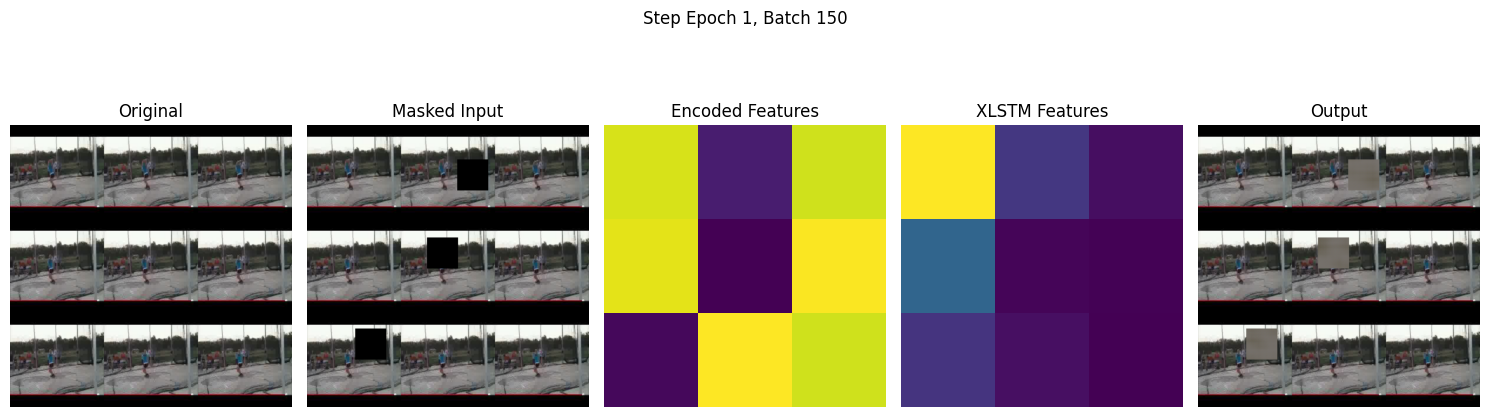

Epoch 1, Batch 150, Loss: 0.0086


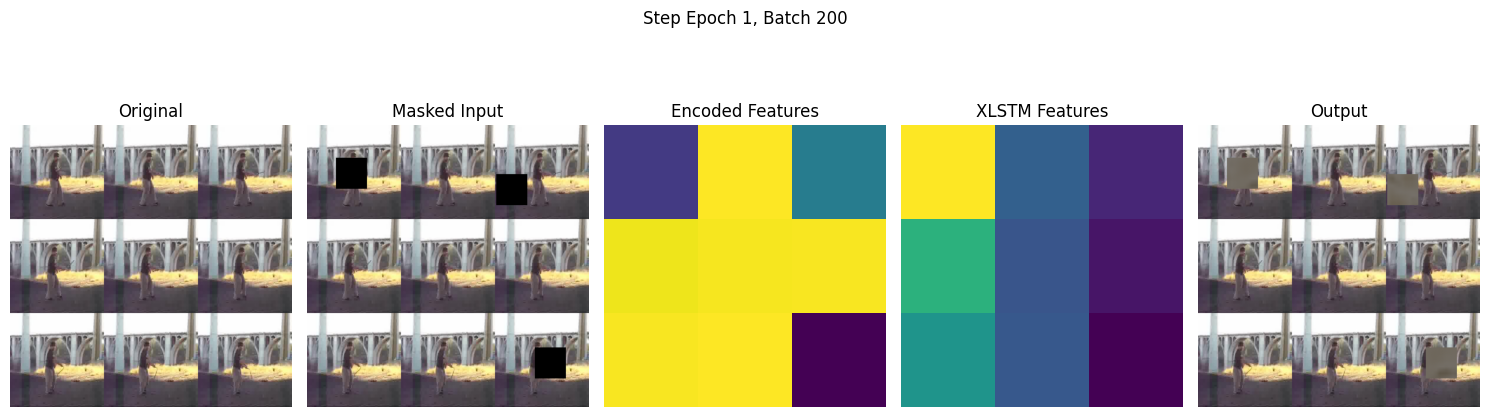

Epoch 1, Batch 200, Loss: 0.0078


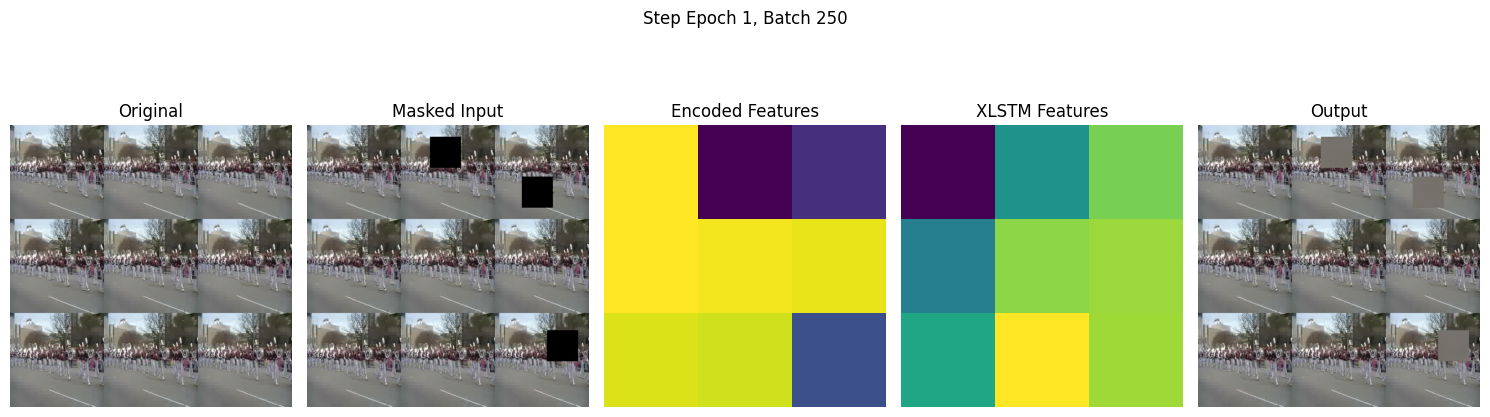

Epoch 1, Batch 250, Loss: 0.0068


In [ ]:
# Create dataset and dataloader
dataset = MaskedImageGridDataset(grouped, image_size=(224, 224), num_masks=3)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Create model
model = FeatureXLSTM(feature_dim=1024, image_size=224, grid_size=3)

# Train
train_model(model, train_loader)

# Dec 29